#Sentiment Analysis with Multilingual E5 Base

##Installing Libraries

In [1]:
import sklearn
from sklearn.metrics import classification_report, f1_score
from sklearn.metrics import f1_score
from torch import Tensor
from torch import nn
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from tqdm.notebook import tqdm
from transformers import AutoTokenizer, AutoModel
from transformers import get_linear_schedule_with_warmup, AutoTokenizer, AutoModel
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

import datetime
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/sentiment analysis/synthetic_train.csv")
df_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/sentiment analysis/synthetic_val.csv")

##Load Data

In [3]:
df_train.head()

,sentence,sentiment,topic
0,Đội ngũ bảo trì quá thưa thớt dẫn đến không đả...,negative,facility
1,The university's musical and artistic faciliti...,neutral,facility
2,Phương pháp giảng dạy phù hợp với các đối tượn...,neutral,curriculum
3,Chương trình học giúp tôi trở thành một chuyên...,positive,curriculum
4,Tôi nghĩ rằng chương trình đào tạo có thể có t...,neutral,curriculum


In [4]:
df_test.head()

,sentence,sentiment,topic
0,Chất lượng vật chất kém.,negative,facility
1,"Phần mềm học tập quá khó sử dụng, khiến sinh v...",negative,facility
2,Trường tôi thiếu những tiện ích cơ bản như máy...,negative,facility
3,Cần tạo thêm các hoạt động gắn kết giữa sinh v...,neutral,curriculum
4,Họ rất khoan dung và lượng giác trong quan điể...,neutral,others


In [5]:
df_train.sentiment.value_counts()

,count
sentiment,
neutral,2724
negative,2711
positive,2709


In [6]:
df_test.sentiment.value_counts()

,count
sentiment,
negative,686
positive,680
neutral,670


In [7]:
df_train['len'] = df_train.sentence.apply(lambda x: len(str(x).split()))
df_test['len'] = df_test.sentence.apply(lambda x: len(str(x).split()))

In [8]:
df_train['len'].describe()

,len
count,8144.000000
mean,15.549730
std,5.018764
min,3.000000
25%,12.000000
50%,15.000000
75%,18.000000
max,43.000000


In [9]:
df_test['len'].describe()

,len
count,2036.000000
mean,15.694990
std,5.185957
min,2.000000
25%,12.000000
50%,15.000000
75%,19.000000
max,48.000000


#Create Data Loader

##Create Tokenizer

In [10]:
tokenizer = AutoTokenizer.from_pretrained('intfloat/multilingual-e5-base')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

##Define Hyper Parameter

In [11]:
epochs = 4
batch_size = 16
init_lr = 2e-5

##Create Text Dataset

In [12]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader

class TextDataset(Dataset):
    def __init__(self, df, tokenizer):
        self.df = df
        self.df = self.df.dropna(subset = ['sentence', 'sentiment'])
        print(self.df['sentiment'].value_counts())
        self.df['label'] = self.df['sentiment'].map(SENTIMENT_MAPPER)
        print(self.df['label'].value_counts())
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        text = str(self.df.iloc[index]['sentence'])
        label = self.df.iloc[index]['label']

        # Tokenize the post and comment
        input_ids = self.tokenizer.encode_plus(text, return_tensors='pt', padding='max_length', max_length=128)

        attention_mask = input_ids["attention_mask"][:, :128].reshape(-1)
        input_ids = input_ids["input_ids"][:, :128].reshape(-1)

        return (input_ids, attention_mask, label)

SENTIMENT_MAPPER = {'positive': 0, 'neutral': 1, 'negative': 2}

# Load the data
train_dataset = TextDataset(df_train, tokenizer)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TextDataset(df_test, tokenizer)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

sentiment
neutral     2724
negative    2711
positive    2709
Name: count, dtype: int64
label
1    2724
2    2711
0    2709
Name: count, dtype: int64
sentiment
negative    686
positive    680
neutral     670
Name: count, dtype: int64
label
2    686
0    680
1    670
Name: count, dtype: int64


#Create Model

##Define Model

In [13]:
class MODEL(nn.Module):
    def __init__(self, num_classes):
        super(MODEL, self).__init__()
        self.model = AutoModel.from_pretrained('intfloat/multilingual-e5-base')
        self.dropout = nn.Dropout(0.3)
        self.linear_layer = nn.Linear(768, num_classes)

    def forward(self, input_ids, attention_mask):
        hidden_states = self.model(input_ids, attention_mask).pooler_output
        hidden_states = self.dropout(hidden_states)
        outpit = self.linear_layer(hidden_states)
        return outpit

# Initialize the model
model = MODEL(3)

config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

##Create Optimizer

In [14]:
optimized_parameters = []
no_decay = ["bias", "LayerNorm.weight", "LayerNorm.bias"]

for name, param in model.named_parameters():
    lr = init_lr
    weight_decay = 0.0 if any(nd in name for nd in no_decay) else 0.01

    if name in ['linear_layer.weight', 'linear_layer.bias'] or 'pooler' in name or 'LinearTransformation' in name:
        lr = init_lr * 3
    elif 'layer.11' in name or 'layer.10' in name or 'layer.9' in name or 'layer.8' in name:
        lr = init_lr * 1.5
    elif 'layer.7' in name or 'layer.6' in name or 'layer.5' in name or 'layer.4' in name:
        lr = init_lr * 2
    else:
        lr = init_lr

    optimized_parameters.append({'params': param,
                                     'weight_decay': weight_decay,
                                     'lr': lr})


optimizer = torch.optim.AdamW(optimized_parameters, lr=init_lr)

##Create Criterion and Learning_rate Scheduler

In [15]:
scaler = torch.cuda.amp.GradScaler()
criterion = nn.CrossEntropyLoss(label_smoothing = 0.2)
total_steps = epochs * len(train_dataloader)
print(total_steps)
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=min(500, total_steps//10),
                                            num_training_steps=total_steps)

2036


<ipython-input-15-959245f13f62>:1: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


#Training

In [16]:
max_acc = 0
max_f1 = 0
train_accuracies = []  # List to store training accuracy for each epoch
test_accuracies = []   # List to store testing accuracy for each epoch

start_train = datetime.now()
model = model.cuda()

for epoch in range(epochs):
    train_acc = 0
    len_train = 0
    model.train()
    start_epoch = datetime.now()

    for batch_idx, (input_ids, attention_mask, label) in enumerate(train_dataloader):
            optimizer.zero_grad()
            input_ids, attention_mask, label = input_ids.cuda(), attention_mask.cuda(), label.cuda()
            label = F.one_hot(label.reshape(-1), 3).float()

            with torch.cuda.amp.autocast():
                predict = model(input_ids, attention_mask)
                loss = criterion(predict, label)
            scaler.scale(loss).backward() #loss.backward()
            scaler.step(optimizer) #optimizer.step()

            scaler.update()

            scheduler.step()

            with torch.no_grad():
                    predict = predict.argmax(-1)
                    train_acc += (predict == label.argmax(-1)).sum().cpu()
                    len_train += len(label)

            if batch_idx % 50 == 0:
                print(batch_idx, train_acc / len_train * 100, loss)

    train_acc = (train_acc / len_train) * 100  # Convert to percentage
    train_accuracies.append(train_acc.item())  # Store the accuracy

    test_acc = 0
    len_test = 0
    model.eval()

    test_labels = []
    test_predicts = []

    for batch_idx, (input_ids, attention_mask, label) in enumerate(test_dataloader):
            input_ids, attention_mask, label = input_ids.cuda(), attention_mask.cuda(), label.cuda()
            label = F.one_hot(label.reshape(-1), 3).float()

            with torch.no_grad():
                with torch.cuda.amp.autocast():
                    predict = model(input_ids, attention_mask)
                    loss = criterion(predict, label)

                    predict = predict.argmax(-1)
                    test_acc += (predict == label.argmax(-1)).sum().cpu()
                    len_test += len(label)

                    test_labels += label.argmax(-1).cpu().numpy().tolist()
                    test_predicts += predict.cpu().numpy().tolist()

            if batch_idx % 100 == 0:
                print(batch_idx, test_acc / len_test * 100, loss)

    test_acc = (test_acc / len_test) * 100  # Convert to percentage
    test_accuracies.append(test_acc.item())  # Store the accuracy

    f1 = f1_score(test_predicts, test_labels, average='macro')

    if test_acc > max_acc:
        max_acc = test_acc
        checkpoint = {'model': model.state_dict()}
        torch.save(checkpoint, "sentiment_max_acc.pt")

    if f1 > max_f1:
        max_f1 = f1
        checkpoint = {'model': model.state_dict()}
        torch.save(checkpoint, "sentiment_max_f1.pt")

    if (epoch + 1) % 1 == 0:
        print(f'Epoch {epoch + 1}, train_acc: {train_acc}, test_acc: {test_acc}, f1: {f1}, epoch_time: {datetime.now() - start_epoch}')

print('total training time: ', datetime.now() - start_train)

<ipython-input-16-a3fccbcc43c2>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


0 tensor(6.2500) tensor(1.1440, device='cuda:0', grad_fn=<DivBackward1>)
50 tensor(45.5882) tensor(1.0003, device='cuda:0', grad_fn=<DivBackward1>)
100 tensor(57.6733) tensor(0.6735, device='cuda:0', grad_fn=<DivBackward1>)
150 tensor(64.4040) tensor(0.7136, device='cuda:0', grad_fn=<DivBackward1>)
200 tensor(68.2525) tensor(0.8475, device='cuda:0', grad_fn=<DivBackward1>)
250 tensor(70.2938) tensor(0.8604, device='cuda:0', grad_fn=<DivBackward1>)
300 tensor(71.5739) tensor(0.6220, device='cuda:0', grad_fn=<DivBackward1>)
350 tensor(73.0947) tensor(0.7937, device='cuda:0', grad_fn=<DivBackward1>)
400 tensor(74.5324) tensor(0.5640, device='cuda:0', grad_fn=<DivBackward1>)
450 tensor(75.7345) tensor(0.6699, device='cuda:0', grad_fn=<DivBackward1>)
500 tensor(76.6218) tensor(0.6485, device='cuda:0', grad_fn=<DivBackward1>)


<ipython-input-16-a3fccbcc43c2>:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


0 tensor(81.2500) tensor(0.6086, device='cuda:0')
100 tensor(86.0148) tensor(0.6033, device='cuda:0')
Epoch 1, train_acc: 76.71905517578125, test_acc: 85.75638580322266, f1: 0.8549095865936103, epoch_time: 0:02:06.232073


<ipython-input-16-a3fccbcc43c2>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


0 tensor(81.2500) tensor(0.6644, device='cuda:0', grad_fn=<DivBackward1>)
50 tensor(83.7010) tensor(0.7396, device='cuda:0', grad_fn=<DivBackward1>)
100 tensor(84.7772) tensor(0.7049, device='cuda:0', grad_fn=<DivBackward1>)
150 tensor(85.9272) tensor(0.7767, device='cuda:0', grad_fn=<DivBackward1>)
200 tensor(86.2562) tensor(0.6221, device='cuda:0', grad_fn=<DivBackward1>)
250 tensor(86.0807) tensor(0.7596, device='cuda:0', grad_fn=<DivBackward1>)
300 tensor(86.4410) tensor(0.6590, device='cuda:0', grad_fn=<DivBackward1>)
350 tensor(86.1823) tensor(0.6208, device='cuda:0', grad_fn=<DivBackward1>)
400 tensor(86.2531) tensor(0.5587, device='cuda:0', grad_fn=<DivBackward1>)
450 tensor(86.6131) tensor(0.5361, device='cuda:0', grad_fn=<DivBackward1>)
500 tensor(86.6891) tensor(0.5633, device='cuda:0', grad_fn=<DivBackward1>)


<ipython-input-16-a3fccbcc43c2>:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


0 tensor(100.) tensor(0.5436, device='cuda:0')
100 tensor(88.4901) tensor(0.5929, device='cuda:0')
Epoch 2, train_acc: 86.75098419189453, test_acc: 88.1630630493164, f1: 0.8811739545223715, epoch_time: 0:02:08.134306


<ipython-input-16-a3fccbcc43c2>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


0 tensor(100.) tensor(0.5183, device='cuda:0', grad_fn=<DivBackward1>)
50 tensor(89.7059) tensor(0.5489, device='cuda:0', grad_fn=<DivBackward1>)
100 tensor(90.7797) tensor(0.6323, device='cuda:0', grad_fn=<DivBackward1>)
150 tensor(90.8526) tensor(0.5166, device='cuda:0', grad_fn=<DivBackward1>)
200 tensor(90.5473) tensor(0.5274, device='cuda:0', grad_fn=<DivBackward1>)
250 tensor(90.4382) tensor(0.6206, device='cuda:0', grad_fn=<DivBackward1>)
300 tensor(90.4070) tensor(0.6342, device='cuda:0', grad_fn=<DivBackward1>)
350 tensor(90.3312) tensor(0.5233, device='cuda:0', grad_fn=<DivBackward1>)
400 tensor(90.4302) tensor(0.5635, device='cuda:0', grad_fn=<DivBackward1>)
450 tensor(90.6181) tensor(0.5169, device='cuda:0', grad_fn=<DivBackward1>)
500 tensor(90.6188) tensor(0.6328, device='cuda:0', grad_fn=<DivBackward1>)


<ipython-input-16-a3fccbcc43c2>:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


0 tensor(87.5000) tensor(0.5548, device='cuda:0')
100 tensor(89.6658) tensor(0.6201, device='cuda:0')
Epoch 3, train_acc: 90.59430694580078, test_acc: 89.44007873535156, f1: 0.8937321500751662, epoch_time: 0:02:03.835394


<ipython-input-16-a3fccbcc43c2>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


0 tensor(100.) tensor(0.5206, device='cuda:0', grad_fn=<DivBackward1>)
50 tensor(94.1176) tensor(0.6268, device='cuda:0', grad_fn=<DivBackward1>)
100 tensor(93.3787) tensor(0.5319, device='cuda:0', grad_fn=<DivBackward1>)
150 tensor(93.5844) tensor(0.5010, device='cuda:0', grad_fn=<DivBackward1>)
200 tensor(93.2525) tensor(0.5589, device='cuda:0', grad_fn=<DivBackward1>)
250 tensor(93.0030) tensor(0.6549, device='cuda:0', grad_fn=<DivBackward1>)
300 tensor(93.3347) tensor(0.5113, device='cuda:0', grad_fn=<DivBackward1>)
350 tensor(93.5007) tensor(0.6131, device='cuda:0', grad_fn=<DivBackward1>)
400 tensor(93.4227) tensor(0.5454, device='cuda:0', grad_fn=<DivBackward1>)
450 tensor(93.3204) tensor(0.5069, device='cuda:0', grad_fn=<DivBackward1>)
500 tensor(93.4506) tensor(0.5609, device='cuda:0', grad_fn=<DivBackward1>)


<ipython-input-16-a3fccbcc43c2>:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


0 tensor(100.) tensor(0.5202, device='cuda:0')
100 tensor(89.6040) tensor(0.6070, device='cuda:0')
Epoch 4, train_acc: 93.41846466064453, test_acc: 89.53831481933594, f1: 0.8949812772847902, epoch_time: 0:02:03.746505
total training time:  0:08:23.163254


#Evaluation

In [17]:
test_acc = 0
len_test = 0

model.load_state_dict(torch.load("sentiment_max_f1.pt")['model'])
test_labels = []
test_predicts = []

for batch_idx, (input_ids, attention_mask, label) in enumerate(test_dataloader):
            input_ids, attention_mask, label = input_ids.cuda(), attention_mask.cuda(), label.cuda()
            label = F.one_hot(label.reshape(-1), 3).float()

            with torch.no_grad():
                with torch.cuda.amp.autocast():
                    predict = model(input_ids, attention_mask)
                    loss = criterion(predict, label)

                    predict = predict.argmax(-1)
                    test_acc += (predict == label.argmax(-1)).sum().cpu()
                    len_test += len(label)

                    test_labels += label.argmax(-1).cpu().numpy().tolist()
                    test_predicts += predict.cpu().numpy().tolist()

            if batch_idx % 100 == 0:
                print(batch_idx, test_acc / len_test * 100, loss)

test_acc = test_acc / len_test
f1 = f1_score(test_predicts, test_labels, average = 'macro')

print(test_acc, f1)

<ipython-input-17-6370463aa5a8>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("sentiment_max_f1.pt")['model'])
<ipython-input-17-6370463a

0 tensor(100.) tensor(0.5202, device='cuda:0')
100 tensor(89.6040) tensor(0.6070, device='cuda:0')
tensor(0.8954) 0.8949812772847902


In [18]:
## label smoothing 0.2
print(sklearn.metrics.classification_report(test_labels, test_predicts, digits=4))

              precision    recall  f1-score   support

           0     0.8471    0.8721    0.8594       680
           1     0.8506    0.8328    0.8416       670
           2     0.9882    0.9796    0.9839       686

    accuracy                         0.8954      2036
   macro avg     0.8953    0.8948    0.8950      2036
weighted avg     0.8958    0.8954    0.8955      2036



In [20]:
from sklearn.metrics import accuracy_score, f1_score, classification_report,confusion_matrix

# Load the model with the best F1 score
model.load_state_dict(torch.load("sentiment_max_f1.pt")['model'])

test_labels = []
test_predicts = []

# Evaluate the model
for batch_idx, (input_ids, attention_mask, label) in enumerate(test_dataloader):
    input_ids, attention_mask, label = input_ids.cuda(), attention_mask.cuda(), label.cuda()
    label = F.one_hot(label.reshape(-1), 3).float()

    with torch.no_grad():
        with torch.cuda.amp.autocast():
            predict = model(input_ids, attention_mask)
            predict = predict.argmax(-1)

            test_labels += label.argmax(-1).cpu().numpy().tolist()
            test_predicts += predict.cpu().numpy().tolist()

# Calculate accuracy as a percentage
accuracy = accuracy_score(test_labels, test_predicts) * 100
print(f"Test Accuracy: {accuracy:.2f}%")

# Optionally, print F1 score and classification report
f1 = f1_score(test_predicts, test_labels, average='macro')
print(f"F1 Score: {f1:.4f}")
print(classification_report(test_labels, test_predicts, digits=4))

<ipython-input-20-89b94ecdc1d6>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("sentiment_max_f1.pt")['model'])
<ipython-input-20-89b94ecd

Test Accuracy: 89.54%
F1 Score: 0.8950
              precision    recall  f1-score   support

           0     0.8471    0.8721    0.8594       680
           1     0.8506    0.8328    0.8416       670
           2     0.9882    0.9796    0.9839       686

    accuracy                         0.8954      2036
   macro avg     0.8953    0.8948    0.8950      2036
weighted avg     0.8958    0.8954    0.8955      2036



#Confusion Matrix

In [21]:
# Function to plot confusion matrix
def plot_confusion_matrix(labels, predictions, classes):
    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

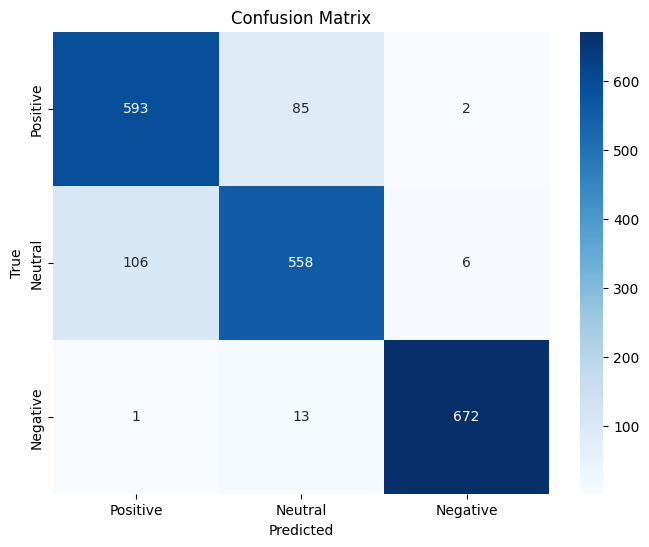

In [22]:
classes = ['Positive', 'Neutral', 'Negative']
plot_confusion_matrix(test_labels, test_predicts, classes)

#Accuracy Graph

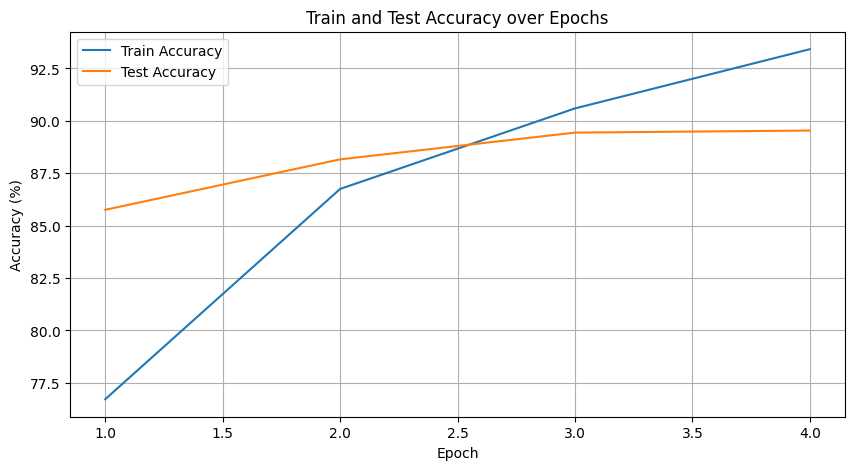

In [23]:
# Plotting the accuracy over epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Train and Test Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()